In [1]:

import pandas as pd 
import numpy as np

file_path = "university_admission_requirements.xlsx"


df = pd.read_excel(file_path)

print("BASIC DATASET INFORMATION")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)


print("NUMERICAL SUMMARY")
print(df.describe(include=[np.number]))

print("CATEGORICAL SUMMARY")
print(df.describe(include=[object]))


print("FIRST FIVE ROWS OF THE DATASET")
display(df.head())

print("MISSING VALUE CHECK")
print(df.isnull().sum())

import matplotlib.pyplot as plt


if "Region" in df.columns:
    df["Region"].value_counts().plot(kind='bar', figsize=(8,4))
    plt.title("Universities by Region")
    plt.xlabel("Region")
    plt.ylabel("Count")
    plt.show()


BASIC DATASET INFORMATION
Number of Rows: 10
Number of Columns: 10

Column Names:
['University', 'Location (State)', 'Average GRE Required', 'Average TOEFL Required', 'Average IELTS Required', 'Minimum CGPA Required', 'Research Preference', 'Acceptance Rate (%)', 'University Rating (1-5)', 'Program Strength Area']

Data Types:
University                  object
Location (State)            object
Average GRE Required         int64
Average TOEFL Required       int64
Average IELTS Required     float64
Minimum CGPA Required      float64
Research Preference         object
Acceptance Rate (%)          int64
University Rating (1-5)    float64
Program Strength Area       object
dtype: object
NUMERICAL SUMMARY
       Average GRE Required  Average TOEFL Required  Average IELTS Required  \
count             10.000000               10.000000               10.000000   
mean             321.700000              100.800000                6.900000   
std                6.129165                5.672546 

,University,Location (State),Average GRE Required,Average TOEFL Required,Average IELTS Required,Minimum CGPA Required,Research Preference,Acceptance Rate (%),University Rating (1-5),Program Strength Area
0,University of Florida,Florida,315,95,7.0,3.0,Yes,31,4.5,"Engineering, Business"
1,Stanford University,California,330,110,7.5,3.8,Yes,4,5.0,"AI, Computer Science, Engineering"
2,Massachusetts Institute of Technology (MIT),Massachusetts,332,110,7.5,3.9,Yes,5,5.0,"AI, Robotics, Technology"
3,"University of California, Berkeley",California,328,105,7.0,3.7,Yes,11,4.8,"Data Science, Engineering, Physics"
4,"University of California, Los Angeles (UCLA)",California,322,100,7.0,3.6,Yes,14,4.7,"Film, Engineering, Medicine"


MISSING VALUE CHECK
University                 0
Location (State)           0
Average GRE Required       0
Average TOEFL Required     0
Average IELTS Required     0
Minimum CGPA Required      0
Research Preference        0
Acceptance Rate (%)        0
University Rating (1-5)    0
Program Strength Area      0
dtype: int64


In [2]:
import hashlib
import json
import re
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

valid_ranges = {
    "Average GRE Required": (130, 340),
    "Average TOEFL Required": (0, 120),
    "Average IELTS Required": (0, 9),
    "Minimum CGPA Required": (0, 10),
    "Acceptance Rate (%)": (0, 100),
    "University Rating (1-5)": (1, 5)
}

missing_threshold = 0.2 
imbalance_threshold = 0.85

In [5]:
# RISK MANAGEMENT

missing_summary = df.isnull().mean()
high_missing = missing_summary[missing_summary > missing_threshold]

# Range checks
range_violations = {}
for col, (low, high) in valid_ranges.items():
    if col in df.columns:
        invalid_rows = df[(df[col] < low) | (df[col] > high)]
        if not invalid_rows.empty:
            range_violations[col] = invalid_rows.shape[0]

# Duplicate detection
duplicates = df[df.duplicated()]
duplicate_count = duplicates.shape[0]

# Basic outlier detection
outlier_counts = {}
for col in df.select_dtypes(include=[np.number]):
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_counts[col] = df[(df[col] < lower) | (df[col] > upper)].shape[0]

# Imbalance check
imbalances = {}
for col in df.select_dtypes(include="object").columns:
    counts = df[col].value_counts(normalize=True)
    if not counts.empty and counts.iloc[0] > imbalance_threshold:
        imbalances[col] = round(counts.iloc[0], 2)

# PII Detection
email_pattern = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
phone_pattern = re.compile(r"\d{3}[-.\s]?\d{3}[-.\s]?\d{4}")
pii_hits = []
for col in df.select_dtypes(include="object"):
    for idx, val in df[col].astype(str).items():
        if email_pattern.search(val) or phone_pattern.search(val):
            pii_hits.append((idx, col, val))


In [8]:
# TRUSTWORTHINESS
from datetime import datetime, timezone


audit_report = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    "file_path": file_path,
    "file_hash": file_hash,
    "rows": df.shape[0],
    "columns": df.shape[1],
    "high_missing_columns": high_missing.to_dict(),
    "range_violations": range_violations,
    "duplicates_found": duplicate_count,
    "outlier_counts": outlier_counts,
    "imbalances_detected": imbalances,
    "pii_hits_count": len(pii_hits),
    "trust_score_estimate": round(
        100
        - (
            len(high_missing) * 5
            + len(range_violations) * 5
            + duplicate_count * 0.1
            + len(imbalances) * 2
            + len(pii_hits) * 10
        ),
        2,
    ),
}


In [9]:
json_path = "data_audit_report.json"
md_path = "data_trustworthiness.md"


with open(json_path, "w") as f:
    json.dump(audit_report, f, indent=4)

# MODEL DEVELOPMENT

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [12]:
print(f"Shape: {df.shape}")
print("\nColumns:\n", df.columns.tolist())

Shape: (10, 10)

Columns:
 ['University', 'Location (State)', 'Average GRE Required', 'Average TOEFL Required', 'Average IELTS Required', 'Minimum CGPA Required', 'Research Preference', 'Acceptance Rate (%)', 'University Rating (1-5)', 'Program Strength Area']


In [21]:
df["Research Preference"] = (
    df["Research Preference"]
    .astype(str)
    .str.strip()
    .str.title()
    .replace({"Nan": None, "N/A": None, "": None})
)
df = df.dropna(subset=["Research Preference"]) 
y = df["Research Preference"].map({"Yes": 1, "No": 0})
valid_idx = y.dropna().index
X, y = df.drop(columns=["Research Preference"]).loc[valid_idx], y.loc[valid_idx]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (8, 9)
Target shape: (8,)


In [18]:
# MODEL INITIALIZATION

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100, random_state=0
)


In [28]:
# FEATURE ENGINEERING

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_features = [
    "Average GRE Required",
    "Average TOEFL Required",
    "Average IELTS Required",
    "Minimum CGPA Required",
    "Acceptance Rate (%)",
    "University Rating (1-5)"
]
cat_features = ["University", "Location (State)", "Program Strength Area"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", rf_model)
])

In [29]:
# EVALUATION

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [30]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
print(f"F1-Score: {f1:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.000
F1-Score: 1.000

Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



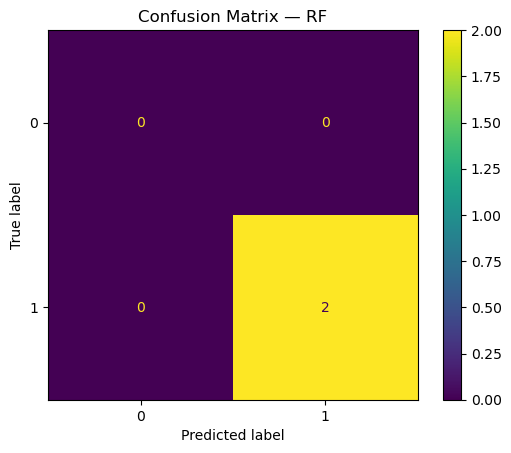

In [32]:
# CONFUSION MATRIX

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, labels=[0, 1]
)
plt.title("Confusion Matrix — RF")
plt.show()


In [34]:
# HYPERPARAMETER TUNING


from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt


param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__max_depth": [None, 5, 10, 15],
    "model__min_samples_split": [2, 4, 6],
    "model__min_samples_leaf": [1, 2, 3],
}

In [36]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

print("Best F1 Score:", round(grid_search.best_score_, 3))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters:
{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best F1 Score: 1.0


In [37]:
best_pipeline = grid_search.best_estimator_

y_pred_best = best_pipeline.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f"Accuracy: {acc_best:.3f}")
print(f"F1 Score: {f1_best:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Accuracy: 1.000
F1 Score: 1.000

Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



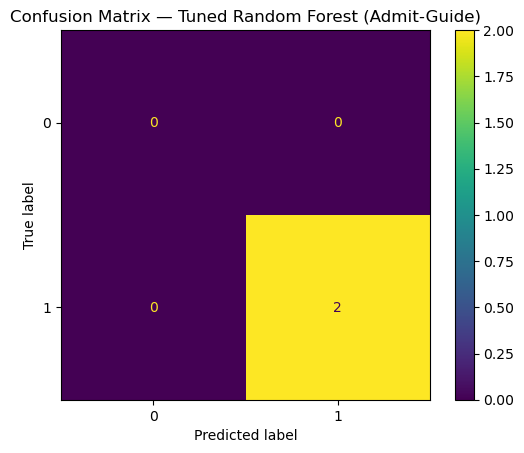

In [38]:
ConfusionMatrixDisplay.from_estimator(best_pipeline, X_test, y_test, labels=[0, 1])
plt.title("Confusion Matrix — Tuned Random Forest")
plt.show()


In [41]:
!pip install shap

   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ---------------------------------------- 547.8/547.8 kB 5.6 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



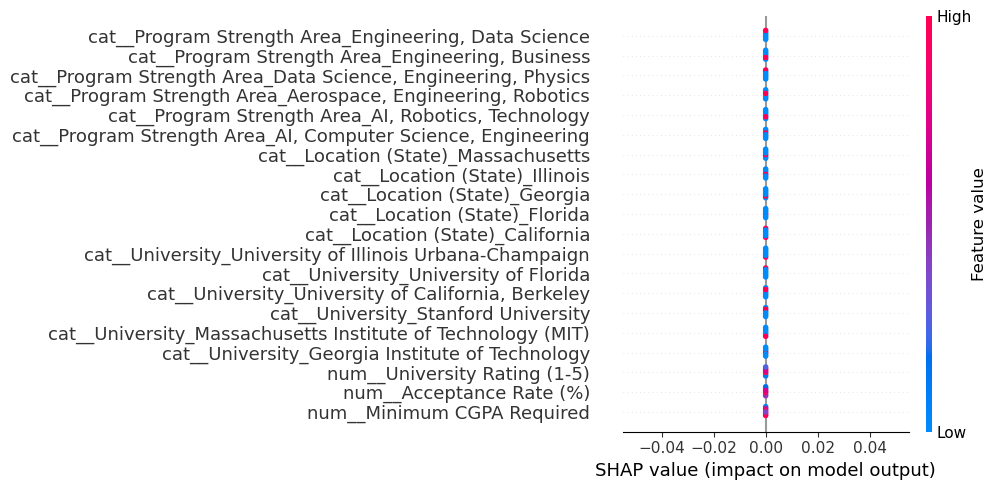

In [44]:
# Explainable AI

import shap

best_model = best_pipeline.named_steps["model"]
X_train_transformed = best_pipeline.named_steps["preprocess"].transform(X_train)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_transformed)

if isinstance(shap_values, list):
    shap_matrix = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_matrix = shap_values

shap.summary_plot(
    shap_matrix,
    X_train_transformed,
    feature_names=best_pipeline.named_steps["preprocess"].get_feature_names_out(),
    plot_size=(10, 5)
)

In [46]:
!pip install fairlearn


In [48]:
# Fairness and Bias Evaluation


from fairlearn.metrics import MetricFrame, selection_rate, accuracy_score_group_min, demographic_parity_difference
import numpy as np

group_feature = X_test["Location (State)"]


metric_frame = MetricFrame(
    metrics={"accuracy": accuracy_score},
    y_true=y_test,
    y_pred=best_pipeline.predict(X_test),
    sensitive_features=group_feature
)


print("Fairness Evaluation (by State)")
print(metric_frame.by_group)

print("\nOverall Accuracy:", metric_frame.overall["accuracy"])
print(
    "Minimum Group Accuracy:",
    accuracy_score_group_min(
        y_true=y_test,
        y_pred=best_pipeline.predict(X_test),
        sensitive_features=group_feature
    )
)
print(
    "Demographic Parity Difference:",
    demographic_parity_difference(
        y_true=y_test,
        y_pred=best_pipeline.predict(X_test),
        sensitive_features=group_feature
    )
)


Fairness Evaluation (by State)
                  accuracy
Location (State)          
California             1.0
Michigan               1.0

Overall Accuracy: 1.0
Minimum Group Accuracy: 1.0
Demographic Parity Difference: 0.0


In [49]:
import joblib

joblib.dump(best_pipeline, "admit_guide_random_forest.pkl")

['admit_guide_random_forest.pkl']